<a href="https://colab.research.google.com/github/sethumdluli/DES-CCF-Detection/blob/main/CCF_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing DESlib package

In [ ]:
!pip install DESlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 158 kB 4.3 MB/s 


Importing relevant libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from scipy import interp
from sklearn import svm
import itertools
%matplotlib inline

from deslib.des import (DESP,
                        KNORAE,
                        KNORAU,
                        KNOP)

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score, 
                             f1_score,
                             roc_auc_score,
                             classification_report)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Importing dataset

In [ ]:
table = pd.read_csv('/content/card_transdata.csv')

Plotting Legitimate to Fraud transactions graph

Text(0.5, 1.0, 'Legitimate vs Fraudulent transactions')

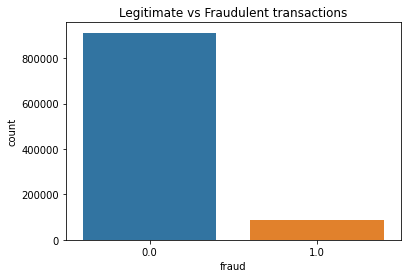

In [ ]:
sns.countplot(table['fraud'])
plt.title('Legitimate vs Fraudulent transactions')

Splitting the dataset

In [ ]:
X = table.drop(columns=['fraud'])
y = table['fraud']

Training the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=40)

Random Undersampling

In [ ]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42, replacement=False)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

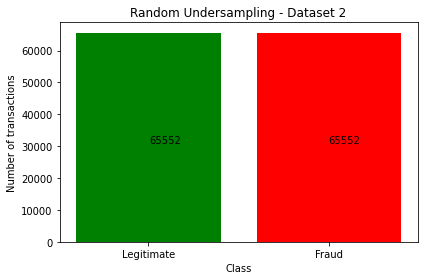

In [ ]:
plt.bar(['Legitimate','Fraud'], [Counter(y_rus)[0], Counter(y_rus)[1]], color=['g', 'r'])
plt.xlabel('Class')
plt.ylabel('Number of transactions')
plt.annotate('{}'.format(Counter(y_rus)[0]), (0.25, 0.45), xycoords='axes fraction')
plt.annotate('{}'.format(Counter(y_rus)[1]), (0.75, 0.45), xycoords='axes fraction')
plt.title('Random Undersampling - Dataset 2')
plt.tight_layout()
plt.show()

Random Oversampling

In [ ]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

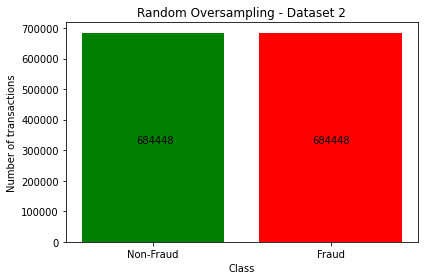

In [ ]:
plt.bar(['Non-Fraud','Fraud'], [Counter(y_ros)[0], Counter(y_ros)[1]], color=['g','r'])
plt.xlabel('Class')
plt.ylabel('Number of transactions')
plt.annotate('{}'.format(Counter(y_ros)[0]), (0.20, 0.45), xycoords='axes fraction')
plt.annotate('{}'.format(Counter(y_ros)[1]), (0.70, 0.45), xycoords='axes fraction')
plt.title('Random Oversampling - Dataset 2')
plt.tight_layout()
plt.show()

SMOTE

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

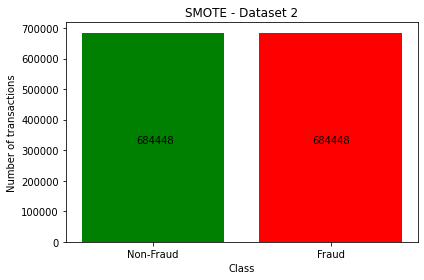

In [ ]:
plt.bar(['Non-Fraud','Fraud'], [Counter(y_smote)[0], Counter(y_smote)[1]], color=['g','r'])
plt.xlabel('Class')
plt.ylabel('Number of transactions')
plt.annotate('{}'.format(Counter(y_smote)[0]), (0.20, 0.45), xycoords='axes fraction')
plt.annotate('{}'.format(Counter(y_smote)[1]), (0.70, 0.45), xycoords='axes fraction')
plt.title('SMOTE - Dataset 2')
plt.tight_layout()
plt.show()

Feature Scaling

In [ ]:
def feature_scaling(X, X_test=X_test):
    std_scale = StandardScaler().fit(X)
    X_std = std_scale.transform(X)
    X_test_std = std_scale.transform(X_test)
    return X_std, X_test_std

In [ ]:
X_rus_std, X_test_rus_std = feature_scaling(X_rus)
X_ros_std, X_test_ros_std = feature_scaling(X_ros)
X_smote_std, X_test_smote_std = feature_scaling(X_smote)

Classifiers

In [ ]:
classifiers = []

classifiers.append(('Decision Tree', DecisionTreeClassifier(criterion='entropy', max_depth=3)))
classifiers.append(('Random Forest', RandomForestClassifier(random_state=42)))
classifiers.append(('XGBoost', XGBClassifier()))

#Ensemble classifier - All classifiers have the same weight
eclf = VotingClassifier(estimators=classifiers, voting='soft', weights=np.ones(len(classifiers)))

Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def Confusion_Matrix(classifier, X_train, y_train, X_test, y_test):
    '''Plots confusion matrix
    '''
    
    name = classifier[0]
    classifier = classifier[1]

    mean_fpr = np.linspace(0, 1, 100)
    class_names = ['Non-Fraud', 'Fraud']
    confusion_matrix_total = [[0, 0], [0, 0]]
    
    #Obtain probabilities for each class
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    #Store the confusion matrix result to plot a table later
    y_pred=classifier.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrix_total += cnf_matrix

    # Plot confusion matrix
    plt.figure()
    plot_confusion_matrix(confusion_matrix_total, classes=class_names, title='Confusion matrix - model: ' + name)

ROC Curve

In [ ]:
def ROC_curve(classifier, X_train, y_train, X_test, y_test):
    '''Plots the ROC curve, and calculates AUC, recall, F1, and precision.'''
    
    name = classifier[0]
    classifier = classifier[1]

    mean_fpr = np.linspace(0, 1, 100)
    class_names = ['Non-Fraud', 'Fraud']
    confusion_matrix_total = [[0, 0], [0, 0]]
    
    #Obtain probabilities for each class
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=1, color='b', label='ROC (AUC = %0.7f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve - model: ' + name)
    plt.legend(loc="lower right")
    plt.show()
    
    #Store the confusion matrix result to plot a table later
    y_pred=classifier.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    confusion_matrix_total += cnf_matrix
    
    #Print precision and recall
    tn, fp = confusion_matrix_total.tolist()[0]
    fn, tp = confusion_matrix_total.tolist()[1]
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = (2 * precision * recall)/ (precision + recall)
    print('Accuracy = {:2.2f}%'.format(accuracy*100))
    print('Precision = {:2.2f}%'.format(precision*100))
    print('Recall = {:2.2f}%'.format(recall*100))
    print('F1 Score = {:2.2f}%'.format(f1_score*100))

Plotting ROC Curve graph and calculating the performance measures for each classifier

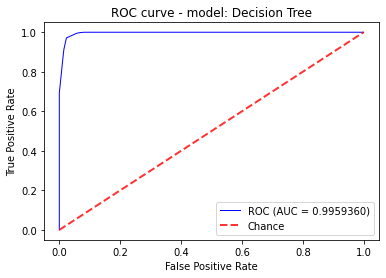

Accuracy = 97.62%
Precision = 79.92%
Recall = 97.13%
F1 Score = 87.69%


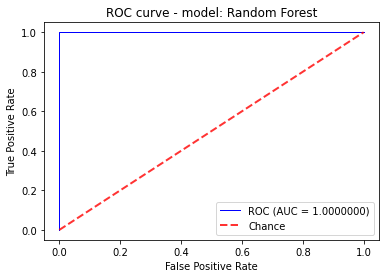

Accuracy = 100.00%
Precision = 99.99%
Recall = 100.00%
F1 Score = 100.00%


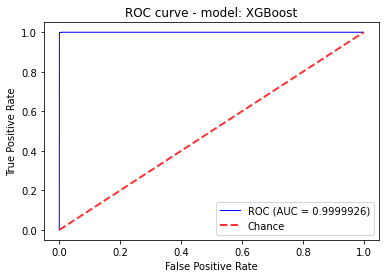

Accuracy = 99.96%
Precision = 99.64%
Recall = 99.89%
F1 Score = 99.76%


In [ ]:
for clf in classifiers:
    ROC_curve(clf, X_smote_std, y_smote, X_test_smote_std, y_test)

ROC Curve and performance measure for ensemble model

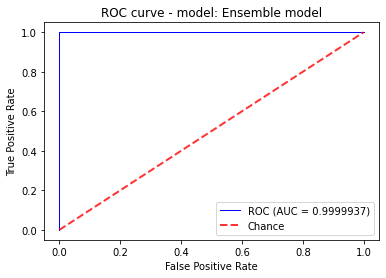

Accuracy = 99.99%
Precision = 99.96%
Recall = 99.89%
F1 Score = 99.92%


In [ ]:
ROC_curve(('Ensemble model', eclf), X_smote_std, y_smote, X_test_smote_std, y_test)

Plotting Confusion Matrix graph for each classifier

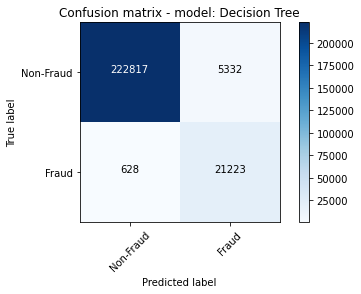

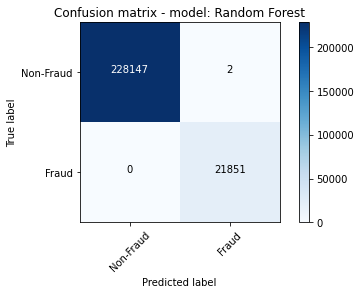

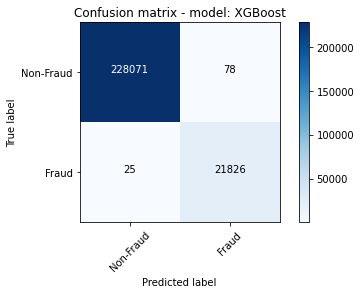

In [ ]:
for clf in classifiers:
    Confusion_Matrix(clf, X_smote_std, y_smote, X_test_smote_std, y_test)

Confusion Matrix graph for ensemble model

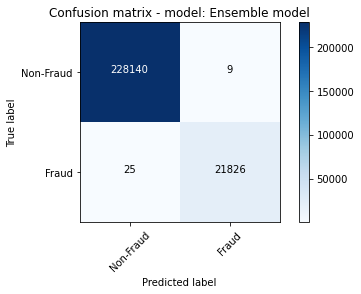

In [ ]:
Confusion_Matrix(('Ensemble model', eclf), X_smote_std, y_smote, X_test_smote_std, y_test)

In [ ]:
def get_results(train_x, train_y, test_x, test_y, classifiers): 
    names = []
    accuracy_list = [] 
    precision_list = []
    recall_list = [] 
    f1_list = []
    
    for cls in classifiers: 
        cls.fit(train_x, train_y)
        y_preds = cls.predict(test_x) 
        
        accuracy = round(cls.score(test_x, test_y), 3) 
        precision = round(precision_score(y_test, y_preds), 3)
        recall = round(recall_score(y_test, y_preds), 3)
        f1 = round(f1_score(y_test, y_preds), 3)
        
        names.append(cls.__class__.__name__)
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
    
    results = {'Models': names, 
               'Accuracy': accuracy_list, 
               'Precision': precision_list, 
               'Recall': recall_list, 
               'F1': f1_list}
    
    resultsDF = pd.DataFrame.from_dict(results)
    
    return resultsDF

Setting parameters for XGBoost algorithm

In [ ]:
params = {'learning_rate': 0.2,
          'max_depth': 2,
          'n_estimators': 200,
          'subsample': 0.9,
          'objective':'binary:logistic'}

Applying Dynamic Ensemble Selection

In [ ]:
rng = np.random.RandomState(42) 
X_train, X_dsel, y_train_en, y_dsel = train_test_split(X_smote, y_smote, test_size=0.40, random_state=rng)

X_trainx = X_train.values
y_train_enx = y_train_en.values

model_rf = RandomForestClassifier(random_state=42)
model_dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model_xgb = XGBClassifier(params = params)


model_dt.fit(X_trainx, y_train_enx)
model_rf.fit(X_trainx, y_train_enx)
model_xgb.fit(X_trainx, y_train_enx)

pool_classifiers = [model_rf, model_xgb, model_dt]

desp = DESP(pool_classifiers)
knorau = KNORAU(pool_classifiers)
kne = KNORAE(pool_classifiers)

des_models = [desp, knorau, kne]

des_results = get_results(X_dsel, y_dsel, X_test, y_test, des_models)

Final results

In [ ]:
des_results

,Models,Accuracy,Precision,Recall,F1
0,DESP,1.0,0.997,0.998,0.997
1,KNORAU,1.0,0.997,0.998,0.997
2,KNORAE,1.0,0.999,0.998,0.999
